# Introduction
* This program that classifies legal issues into a binary value for each National Subject Matter Index (NSMI). (https://nsmi.lsntap.org/browse-v2) \\
"Category" means 20 indexes. \\
"Class" means sub categories under the category.

### Data
* The data contains 2777 labeled articles. Each article has a binary value(0 or 1) that indicates if this article is related to a specific legal class. We ignore unlabeled entries when constructing a model.

### Implementation
* The program converts an article into tf-idf and applies multinomial Naive-Bayes model provided by scikit-learn. 

* After preprocessing data, we predict the model with 10-fold cross-validation.

### Output
* We calculate accuracy with bot categories(20) and classes(100+). \\

See overall result is at the bottom of this notebook.

In [1]:
import time
start_time = time.time()

# Data Preparation (DONE)

In [2]:
SOLVER = 'liblinear' 
PENALTY = "l1"


!pip3 install PrettyTable
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install tqdm
!pip3 install nltk
!python3 -m nltk.downloader stopwords punkt
!python3 -m pip install prettytable
from prettytable import PrettyTable
from collections import defaultdict

import collections
import os
import sys


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl

import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import brier_score_loss


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from tqdm.notebook import tqdm

pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None) 
print("DONE")

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /Users/heeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/heeh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


DONE


In [3]:
url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


,_id,full_text,BE-00-00-00-00,BE-01-00-00-00
0,5b60e59cda52255c20cff794,Will he serve time?. Long story short my broth...,0.0,0.0
1,5b60e59cda52255c20cff79a,Groundwater leaking out of street 24/7. Ground...,0.0,0.0
2,5b60e59cda52255c20cff7a0,How do I get my mom's license taken away. My m...,0.0,0.0
3,5b60e59cda52255c20cff7bf,My boss hasn't paid me. What do i do?. I work ...,NaN,NaN
4,5b60e59cda52255c20cff7b8,"[Texas] I signed a non-compete contract, but t...",0.0,0.0
...,...,...,...,...
2772,5b60e66dda52255c20df433f,Do you and your parents get deported because o...,0.0,0.0
2773,5b60e66dda52255c20df43ae,Wondering the legality of a minor (me) being a...,0.0,0.0
2774,5b60e66dda52255c20df4462,Can I sue a billion dollar company in small cl...,0.0,0.0
2775,5b60e66dda52255c20df4448,Sued by creditor and currently in settlement n...,0.0,0.0


## Null and Rowsum Check

In [4]:
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)

# Remove columns that have <10 positive classes

In [5]:
oldCols = list(df.columns)
print(len(oldCols))
newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)        
print(len(newCols))
cols = oldCols[:2] + newCols
print(cols)
print(len(cols))
df = df[cols]
df.sum(axis=0, skipna=True)

88
36
['_id', 'full_text', 'BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']
38


_id               5b60e59cda52255c20cff7945b60e59cda52255c20cff7...
full_text         Will he serve time?. Long story short my broth...
BE-00-00-00-00                                                   27
BU-00-00-00-00                                                   93
CO-00-00-00-00                                                  106
CR-00-00-00-00                                                  302
CR-01-00-00-00                                                   12
CR-04-00-00-00                                                   13
CR-06-00-00-00                                                   11
CR-10-00-00-00                                                   11
ED-00-00-00-00                                                   24
ES-00-00-00-00                                                   78
ES-01-00-00-00                                                   10
ES-03-00-00-00                                                   13
FA-00-00-00-00                                  

# Tiny Example: Crime and Prison(CR-00-00-00-00)


## Preprocessing (DONE)

In [6]:

verbose = True
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))



## Data Preparation

In [7]:
cls = 'CR-00-00-00-00'
dfset = defaultdict() 
preprocessing(dfset, cls)    

#    model[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())



------------Before dropping nan----------------------------------------
                                              full_text  CR-00-00-00-00
0     Will he serve time?. Long story short my broth...             1.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             1.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1377
NaN    1098
1.0     302
Nam

In [8]:
class_list = df.columns[2:].tolist()

for cls in tqdm(class_list):
    preprocessing(dfset, cls)

------------Before dropping nan----------------------------------------
                                              full_text  BE-00-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             0.0
3     My boss hasn't paid me. What do i do?. I work ...             NaN
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             0.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1821
NaN     929
1.0      27
Nam


------------After dropping nan---------------------------------------
                                              full_text  GO-00-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             1.0
3     My boss hasn't paid me. What do i do?. I work ...             0.0
5     TX - TSA and Police accidental law broken. Oka...             0.0
6     Eviction. I got an eviction notice from my lan...             0.0
...                                                 ...             ...
2762  (va) if I were. We moved to special education ...             0.0
2767  QC, Canada. How many seconds of a clip can I u...             0.0
2771  [GA] At what point does poor quality of care b...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[1517 rows x 2 columns]
0.0    1504
1.0      13
Name: GO-00-00-0

Name: HO-09-00-00-00, dtype: int64
------------Before dropping nan----------------------------------------
                                              full_text  IM-00-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             0.0
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             1.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0 

# TF-IDF

## Vectorizer

In [9]:
tfidf_dict = defaultdict()
tinydf = dfset[cls]
X = tinydf['full_text'].values
for cls in tqdm(class_list):
    X = dfset[cls]['full_text'].values
    tfidf_dict[cls] = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3)
    tfidf_dict[cls].fit(X)
    print("Dimension[" + cls + "]: ", len(tfidf_dict[cls].vocabulary_))

Dimension[BE-00-00-00-00]:  152069
Dimension[BU-00-00-00-00]:  134183
Dimension[CO-00-00-00-00]:  102810
Dimension[CR-00-00-00-00]:  139065
Dimension[CR-01-00-00-00]:  117677
Dimension[CR-04-00-00-00]:  118327
Dimension[CR-06-00-00-00]:  118623
Dimension[CR-10-00-00-00]:  158456
Dimension[ED-00-00-00-00]:  151085
Dimension[ES-00-00-00-00]:  158705
Dimension[ES-01-00-00-00]:  153910
Dimension[ES-03-00-00-00]:  161578
Dimension[FA-00-00-00-00]:  167675
Dimension[FA-05-00-00-00]:  162968
Dimension[FA-06-00-00-00]:  148090
Dimension[FA-07-00-00-00]:  159031
Dimension[GO-00-00-00-00]:  130127
Dimension[HE-00-00-00-00]:  155388
Dimension[HO-00-00-00-00]:  173551
Dimension[HO-06-00-00-00]:  136163
Dimension[HO-09-00-00-00]:  135432
Dimension[IM-00-00-00-00]:  160795
Dimension[MO-00-00-00-00]:  120659
Dimension[MO-02-00-00-00]:  158425
Dimension[MO-07-00-00-00]:  94966
Dimension[MO-10-00-00-00]:  91951
Dimension[RI-00-00-00-00]:  117085
Dimension[TO-00-00-00-00]:  98110
Dimension[TR-00-00-00-0

## TF-IDF Simple Prediction

In [10]:
import warnings
warnings.filterwarnings('ignore') 

cls = 'CR-00-00-00-00'
tinydf = dfset[cls]
X = tinydf['full_text'].values
Y = tinydf[cls].values

p = len(X) // 10 * 9
X_train_tfidf_vect = tfidf_dict[cls].transform(X[0:p])
X_test_tfidf_vect = tfidf_dict[cls].transform(X[p:])

model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced')
model.fit(X_train_tfidf_vect, Y[0:p])
preds = model.predict(X_test_tfidf_vect)
precision, recall, fscore, support = score(Y[p:], preds, average='binary')
print('accuracy : {0:.4f}'.format(accuracy_score(Y[p:], preds)))
print('precision: {0:.4f}'.format(precision))
print('recall   : {0:.4f}'.format(recall))
print('fscore   : {0:.4f}'.format(fscore))

print("TF-IDF Dimension: ", len(tfidf_dict[cls].vocabulary_))


accuracy : 0.9375
precision: 0.7500
recall   : 0.7826
fscore   : 0.7660
TF-IDF Dimension:  139065


## TF-IDF + Logistic Regression Cross Validation

In [11]:

def predict_by_class_tfidf(dfset: defaultdict,cls: str, model) -> float:
    global tfidf_dict
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []
    preds = [0] * len(Y)

    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index] 
        
#        tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3)
#        tfidf_vect.fit(X_train)
        X_train_tfidf = tfidf_dict[cls].transform(X_train)
        X_test_tfidf = tfidf_dict[cls].transform(X_test)

        #X_train_tfidf = tfidf_vect.transform(X_train)
        #X_test_tfidf = tfidf_vect.transform(X_test)
        
        model.fit(X_train_tfidf, Y_train)
        out = model.predict(X_test_tfidf)
        i = 0
        for x in test_index:
            preds[x] = out[i]
            i += 1
        n_iter += 1
        
    accuracy = accuracy_score(Y, preds)
    precision, recall, fscore, support = score(Y, preds)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall: tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    accuracy = np.round(accuracy, 4)
    precision[1] = np.round(precision[1], 4)
    recall[1] = np.round(recall[1], 4)
    fscore[1] = np.round(fscore[1], 4)
    support[1] = np.round(support[1], 4)    
    return (accuracy, precision[1], recall[1], fscore[1], support[1])

verbose = False 
numdoc = defaultdict()
model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000, tol=0.01)

cls = 'CR-00-00-00-00'
predict_by_class_tfidf(dfset, cls, model)

------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679


(0.8952, 0.7188, 0.6854, 0.7017, 302)

## TFIDF Hyperparameter Selection 

------------------------------------

Class:  CR-00-00-00-00
0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
C: 4096.0 Loss:  0.2457
C: 2048.0 Loss:  0.2338
C: 1024.0 Loss:  0.2359
C: 512.0 Loss:  0.244
C: 256.0 Loss:  0.2645
C: 128.0 Loss:  0.269
C: 64.0 Loss:  0.2513
C: 32.0 Loss:  0.2313
C: 16.0 Loss:  0.2187
C: 8.0 Loss:  0.2217
C: 4.0 Loss:  0.2527
C: 2.0 Loss:  0.3148
(0.9196, 0.8224, 0.7053, 0.7594, 302, 0.2187, 0.0583, 16.0, 1679)
LogisticRegression(C=16.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=5000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False)
12


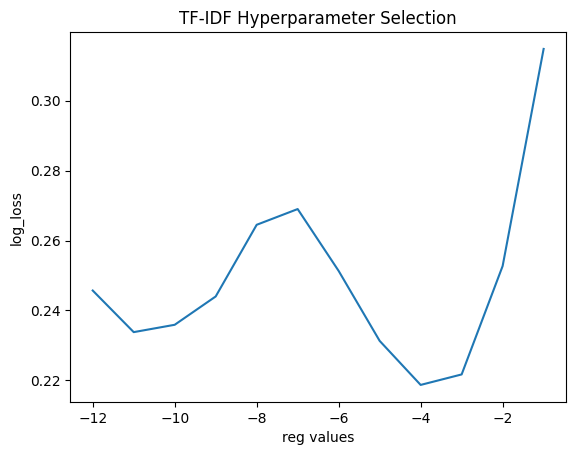

16.0


In [34]:
def predict_by_class_gridcv(dfset: defaultdict,cls: str):
    global PENALTY, SOLVER
    global tfidf_dict
    print('------------------------------------\n')
    print('Class: ', cls)
    #preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values

    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []
    preds = [0] * len(Y)
    probs = [0] * len(Y)
    
    best_recall = 0
    best_accuracy = 0
    best_precision = 0
    best_fscore = 0
    best_support = 0
    best_model = 0
    
    best_c = 0
    
    best_logloss = 1
    
    best_brierloss = 1
    
    for c in [1.0/2.0**reg for reg in np.arange(-12, 0)]:

        model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', C = c, max_iter=5000, tol=0.001)
    
        for train_index, test_index in kfold.split(X, Y):
            X_train, X_test = X[train_index], X[test_index] 
            Y_train, Y_test = Y[train_index], Y[test_index] 

#            X_train_tfidf = tfidf_vect.transform(X_train)
#            X_test_tfidf = tfidf_vect.transform(X_test)
            X_train_tfidf = tfidf_dict[cls].transform(X_train)
            X_test_tfidf = tfidf_dict[cls].transform(X_test)

            model.fit(X_train_tfidf, Y_train)
            out = model.predict(X_test_tfidf)
            prob = model.predict_proba(X_test_tfidf)[:,1]
            i = 0
            for x in test_index:
                preds[x] = out[i]
                probs[x] = prob[i]
                i += 1
            n_iter += 1

        custom_logloss = np.round(log_loss(Y, probs), 4)
        custom_brierloss = np.round(brier_score_loss(Y, probs), 4)  

        c_list.append(c)
        loss_list.append(custom_logloss)
        
        print('C:', c, end=' ')
        print('Loss: ', np.round(custom_logloss, 4))
        
        
        
        
        accuracy = accuracy_score(Y, preds)
        precision, recall, fscore, support = score(Y, preds)
        # accuracy: (tp + tn) / (p + n)
        # precision tp / (tp + fp)
        # recall: tp / (tp + fn)
        # f1: 2 tp / (2 tp + fp + fn)
        accuracy = np.round(accuracy, 4)
        precision[1] = np.round(precision[1], 4)
        recall[1] = np.round(recall[1], 4)
        fscore[1] = np.round(fscore[1], 4)
        support[1] = np.round(support[1], 4)    
#        print(accuracy, precision[1], recall[1], fscore[1], support[1])
        
        #if best_recall < recall[1]: #For best recall score
        if best_logloss > custom_logloss: 
            best_logloss = custom_logloss
            best_accuracy = accuracy
            best_recall = recall[1]
            best_precision = precision[1]
            best_fscore = fscore[1]
            best_support = support[1]
            best_model = model
            best_c = c
        if best_brierloss > custom_brierloss:
            best_brierloss = custom_brierloss
            
    classifier[cls] = best_model
    return (best_accuracy, best_precision, best_recall, best_fscore, best_support, best_logloss, best_brierloss, best_c, numdoc[cls])


c_list = []
loss_list = []

classifier = defaultdict()
numdoc = defaultdict()
cls = 'CR-00-00-00-00'
print(predict_by_class_gridcv(dfset, cls))
print(classifier[cls])

print(len(loss_list))

# plotting the points  
plt.plot(range(-12,0), loss_list)  
plt.xlabel('reg values') 
plt.ylabel('log_loss') 
plt.title('TF-IDF Hyperparameter Selection') 
plt.show() 
print(classifier[cls].C)


# Entire Data 

## Build Models and Calculating Accuracies

In [35]:
class_list = df.columns[2:].tolist()
print(class_list)
verbose = False
stat_dict = defaultdict() 
for cls in tqdm(class_list):
    ret = predict_by_class_gridcv(dfset, cls)
    stat_dict[cls] = ret 
    print('statistics' , ret)

['BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']


------------------------------------

Class:  BE-00-00-00-00
0.0    1821
1.0      27
Name: BE-00-00-00-00, dtype: int64
data set size 1848
C: 4096.0 Loss:  0.0845
C: 2048.0 Loss:  0.0807
C: 1024.0 Loss:  0.0781
C: 512.0 Loss:  0.0738
C: 256.0 Loss:  0.072
C: 128.0 Loss:  0.0688
C: 64.0 Loss:  0.0649
C: 32.0 Loss:  0.06
C: 16.0 Loss:  0.055
C: 8.0 Loss:  0.0561
C: 4.0 Loss:  0.0631
C: 2.0 Loss:  0.0832
statistics (0.9881, 0.6471, 0.4074, 0.5, 27, 0.055, 0.0109, 16.0, 1848)
------------------------------------

Class:  BU-00-00-00-00
0.0    1497
1.0      93
Name: BU-00-00-00-00, dtype: int64
data set size 1590
C: 4096.0 Loss:  0.1181
C: 2048.0 Loss:  0.126
C: 1024.0 Loss:  0.1317
C: 512.0 Loss:  0.1424
C: 256.0 Loss:  0.1409
C: 128.0 Loss:  0.1378
C: 64.0 Loss:  0.1314
C: 32.0 Loss:  0.1195
C: 16.0 Loss:  0.112
C: 8.0 Loss:  0.1126
C: 4.0 Loss:  0.1284
C: 2.0 Loss:  0.174
statistics (0.9654, 0.7714, 0.5806, 0.6626, 93, 0.112, 0.0277, 16.0, 1590)
------------------------------------

Clas

C: 4096.0 Loss:  0.1202
C: 2048.0 Loss:  0.1116
C: 1024.0 Loss:  0.1111
C: 512.0 Loss:  0.1201
C: 256.0 Loss:  0.1151
C: 128.0 Loss:  0.1111
C: 64.0 Loss:  0.1077
C: 32.0 Loss:  0.1012
C: 16.0 Loss:  0.0952
C: 8.0 Loss:  0.0961
C: 4.0 Loss:  0.1092
C: 2.0 Loss:  0.1465
statistics (0.9716, 0.8333, 0.6967, 0.7589, 122, 0.0952, 0.0215, 16.0, 1900)
------------------------------------

Class:  HO-00-00-00-00
0.0    1582
1.0     550
Name: HO-00-00-00-00, dtype: int64
data set size 2132
C: 4096.0 Loss:  0.153
C: 2048.0 Loss:  0.1453
C: 1024.0 Loss:  0.1367
C: 512.0 Loss:  0.1306
C: 256.0 Loss:  0.1225
C: 128.0 Loss:  0.1154
C: 64.0 Loss:  0.1169
C: 32.0 Loss:  0.1166
C: 16.0 Loss:  0.1143
C: 8.0 Loss:  0.115
C: 4.0 Loss:  0.1268
C: 2.0 Loss:  0.1568
statistics (0.9611, 0.9431, 0.9036, 0.9229, 550, 0.1143, 0.0288, 16.0, 2132)
------------------------------------

Class:  HO-06-00-00-00
0.0    1628
1.0      34
Name: HO-06-00-00-00, dtype: int64
data set size 1662
C: 4096.0 Loss:  0.0686
C: 204

C: 2048.0 Loss:  0.1695
C: 1024.0 Loss:  0.1616
C: 512.0 Loss:  0.1524
C: 256.0 Loss:  0.1635
C: 128.0 Loss:  0.1692
C: 64.0 Loss:  0.1611
C: 32.0 Loss:  0.1503
C: 16.0 Loss:  0.1441
C: 8.0 Loss:  0.1461
C: 4.0 Loss:  0.167
C: 2.0 Loss:  0.2106
statistics (0.9493, 0.9133, 0.8165, 0.8622, 387, 0.1441, 0.0334, 16.0, 1991)
------------------------------------

Class:  WO-03-00-00-00
0.0    1607
1.0      10
Name: WO-03-00-00-00, dtype: int64
data set size 1617
C: 4096.0 Loss:  0.0479
C: 2048.0 Loss:  0.0463
C: 1024.0 Loss:  0.0457
C: 512.0 Loss:  0.0425
C: 256.0 Loss:  0.0396
C: 128.0 Loss:  0.0393
C: 64.0 Loss:  0.0384
C: 32.0 Loss:  0.0374
C: 16.0 Loss:  0.0379
C: 8.0 Loss:  0.0398
C: 4.0 Loss:  0.0452
C: 2.0 Loss:  0.0599
statistics (0.9932, 0.4286, 0.3, 0.3529, 10, 0.0374, 0.0047, 32.0, 1617)



In [46]:
import pickle

#with open('vectorizers_tfidf_l1.pckl', 'wb') as handle:
#    pickle.dump(tfidf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open("models_tfidf_l1.pckl", "wb") as f:
    for val in classifier.items():
         pickle.dump(val, f)
            
with open("stats_tfidf_l1.pckl", "wb") as f:
    for val in stat_dict.items():
         pickle.dump(val, f)
            
with open("vectorizers_tfidf_l1.pckl", "wb") as f:
    for val in tfidf_dict.items():
         pickle.dump(val, f)

## Distribution

In [37]:

t = PrettyTable(["class", "accuracy", "precision", "recall", "F1", "support", "log_loss", "brier_loss", "C", "|documents|"])
#t.align["class"] = "r"
t.align["accuracy"] = "r"
t.align["precision"] = "r"
t.align["recall"] = "r"
t.align["F1 score"] = "r"
t.align["support"] = "r"
t.align["log_loss"] = "r"
t.align["brier_loss"] = "r"
t.align["C"] = "r"

for k,v in stat_dict.items():
    t.add_row([k, v[0], v[1], v[2], v[3], v[4], v[5], v[6], v[7], numdoc[k]])
    
print(t)

+----------------+----------+-----------+--------+--------+---------+----------+------------+-------+-------------+
|     class      | accuracy | precision | recall |   F1   | support | log_loss | brier_loss |     C | |documents| |
+----------------+----------+-----------+--------+--------+---------+----------+------------+-------+-------------+
| BE-00-00-00-00 |   0.9881 |    0.6471 | 0.4074 |  0.5   |      27 |    0.055 |     0.0109 |  16.0 |     1848    |
| BU-00-00-00-00 |   0.9654 |    0.7714 | 0.5806 | 0.6626 |      93 |    0.112 |     0.0277 |  16.0 |     1590    |
| CO-00-00-00-00 |   0.9424 |    0.6893 | 0.6698 | 0.6794 |     106 |    0.159 |     0.0398 |   8.0 |     1164    |
| CR-00-00-00-00 |    0.919 |    0.8217 |  0.702 | 0.7571 |     302 |    0.219 |     0.0575 |  16.0 |     1679    |
| CR-01-00-00-00 |   0.9878 |    0.2727 |   0.25 | 0.2609 |      12 |   0.0497 |     0.0084 |   8.0 |     1393    |
| CR-04-00-00-00 |   0.9886 |       0.2 | 0.0769 | 0.1111 |      13 |   

## Plotting for Top10 classes

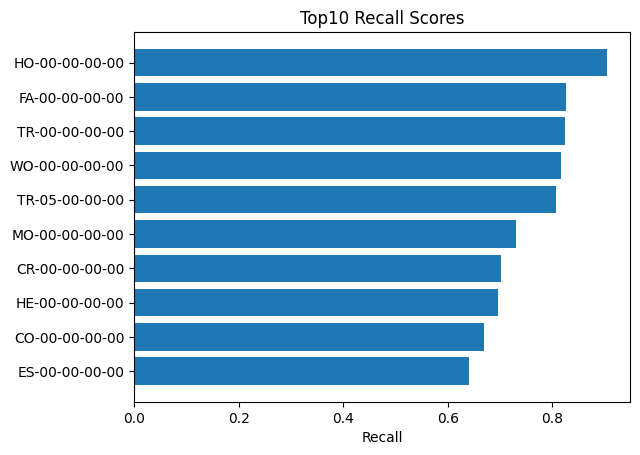

In [38]:
#for k,v in accuracy_dict.items():
#    print(k,v)
#sys.exit()


# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1], reverse=True)
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])

ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Top10 Recall Scores')

plt.show()

## Bottom 10

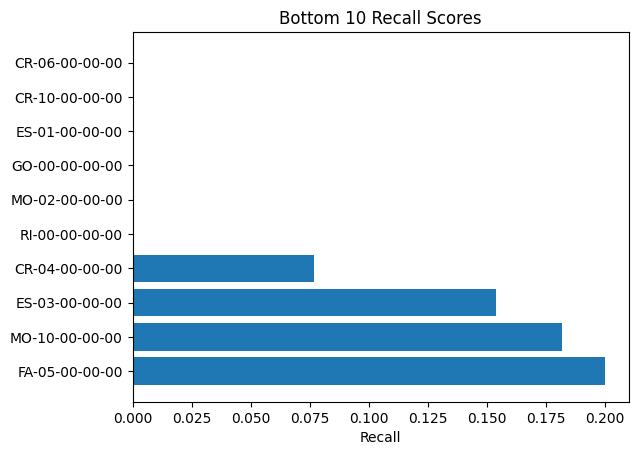

In [39]:
#for k,v in accuracy_dict.items():
#    print(k,v)
#sys.exit()

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]
    
sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1])
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])




ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Bottom 10 Recall Scores')

plt.show()

## Recall Distribution

    Recall
0    40.74
1    58.06
2    66.98
3    70.20
4    25.00
5     7.69
6     0.00
7     0.00
8    50.00
9    64.10
10    0.00
11   15.38
12   82.63
13   20.00
14   40.00
15   21.95
16    0.00
17   69.67
18   90.36
19   55.88
20   40.74
21   50.00
22   72.95
23    0.00
24   46.15
25   18.18
26    0.00
27   63.04
28   82.31
29   50.00
30   34.48
31   23.53
32   40.00
33   80.65
34   81.65
35   30.00


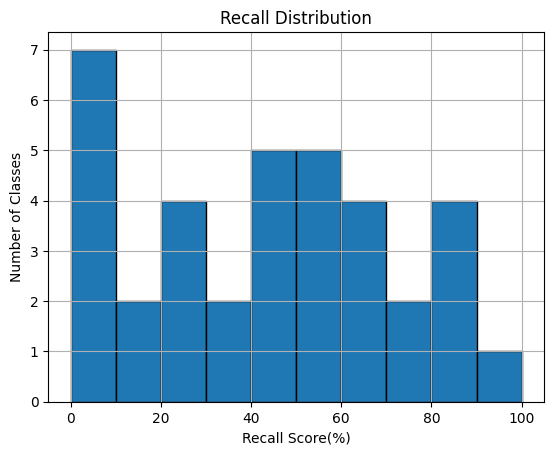

In [40]:

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

recall_list = []
for k,v in recall_dict.items():
    recall_list.append(v*100)
   
d = {'Recall': recall_list}
tinydf = pd.DataFrame(data=d)



hist = tinydf.hist(edgecolor='black', bins = [0,10,20,30,40,50,60,70,80,90,100])
pl.title("Recall Distribution")
pl.xlabel("Recall Score(%)")
pl.ylabel("Number of Classes")
print(tinydf)

## log_loss histogram

    logloss
0    0.0550
1    0.1120
2    0.1590
3    0.2190
4    0.0497
5    0.0547
6    0.0469
7    0.0423
8    0.0355
9    0.0772
10   0.0401
11   0.0394
12   0.1549
13   0.0287
14   0.0177
15   0.0889
16   0.0682
17   0.0952
18   0.1143
19   0.0601
20   0.0451
21   0.0429
22   0.2928
23   0.0467
24   0.0400
25   0.0565
26   0.0918
27   0.2811
28   0.1112
29   0.0537
30   0.0665
31   0.0489
32   0.0454
33   0.0205
34   0.1441
35   0.0374


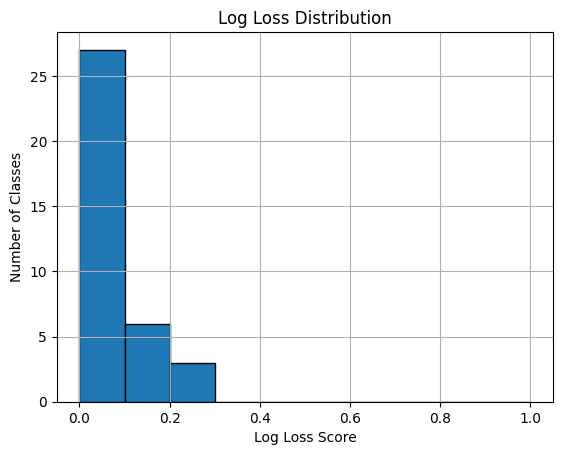

In [41]:
logloss_dict = defaultdict()
for k,v in stat_dict.items():
    logloss_dict[k] = v[5]

logloss_list = []
for k,v in logloss_dict.items():
    logloss_list.append(v)
   
d = {'logloss': logloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Log Loss Distribution")
pl.xlabel("Log Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

## Brier Score Loss

    brierloss
0      0.0109
1      0.0277
2      0.0398
3      0.0575
4      0.0084
5      0.0100
6      0.0081
7      0.0060
8      0.0079
9      0.0154
10     0.0059
11     0.0068
12     0.0407
13     0.0055
14     0.0032
15     0.0193
16     0.0086
17     0.0215
18     0.0288
19     0.0113
20     0.0091
21     0.0098
22     0.0810
23     0.0067
24     0.0087
25     0.0093
26     0.0162
27     0.0783
28     0.0255
29     0.0103
30     0.0128
31     0.0083
32     0.0078
33     0.0046
34     0.0334
35     0.0047


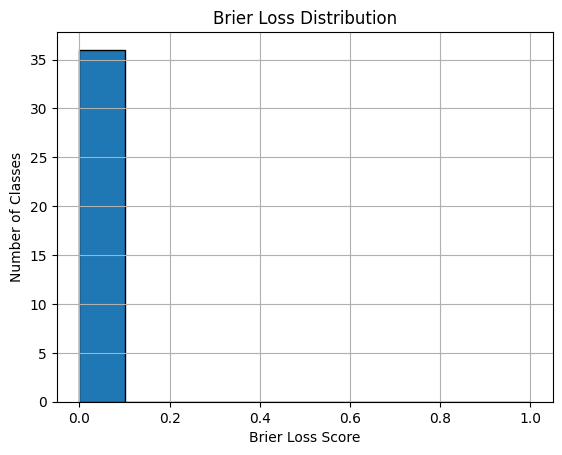

In [42]:
brierloss_dict = defaultdict()
for k,v in stat_dict.items():
    brierloss_dict[k] = v[6]

brierloss_list = []
for k,v in brierloss_dict.items():
    brierloss_list.append(v)
   
d = {'brierloss': brierloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Brier Loss Distribution")
pl.xlabel("Brier Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

# Custom Input Prediction

In [43]:
#text = "How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY state, not very helpful. Can i contact her insurance? Do I contact the police? Has this happened to anyone"
text = "I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take?"

print(text)

predictions = defaultdict() 
prob = defaultdict()




for cls in class_list:
    text_tfidf = tfidf_dict[cls].transform([text])
    predictions[cls] = classifier[cls].predict(text_tfidf)
    prob[cls] = classifier[cls].predict_proba(text_tfidf)[:,1]

for k,v in predictions.items():   
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k], 4))


I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take?
CR-00-00-00-00 [1.] [1.]
CR-01-00-00-00 [1.] [0.9999]
MO-00-00-00-00 [1.] [0.9899]
TO-00-00-00-00 [1.] [0.9765]
TR-00-00-00-00 [1.] [1.]
TR-02-00-00-00 [1.] [0.7331]
TR-04-00-00-00 [1.] [0.9998]
TR-05-00-00-00 [1.] [0.8779]


In [44]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 13522.456758022308 seconds ---


In [45]:
import sys
sys.stdout.write('\a')
sys.stdout.flush()

